# 생성 모델링(Generative Modeling)
---

기존의 이미지를 분류한 것은 판별 모델링.<br>
* 판별 모델 : 입력된 데이터셋을 특정 기준에 따라 분류하거나, 특정 값을 맞히는 모델<br>
* 생성 모델 : 학습한 데이터셋과 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델

> * 예시: 간단한 피아노 선율만을 입력하면 기타, 드럼, 베이스 등의 다른 악기 모두가 어울리는 복합 음악을 만들어내는 DeepComposer
> * [AWS의 DeepComposer](https://www.youtube.com/watch?v=XH2EbK9dQlg)<br>

---
### 예시  모델 1. 그림을 사진으로 변환: Pix2Pix
Pix2Pix는 간단한 이미지를 입력할 경우 실제 사진처럼 보이도록 바꿔줄 때 주로 사용.<br>
이미지(Input Image) 와 실제 이미지(Ground Truth) 가 쌍을 이루는 데이터셋으로 학습을 진행함.
![pix2pix](pix2pix.png)
> [Image-to-Image Translation with Conditional Adversarial Networks 논문](https://arxiv.org/pdf/1611.07004.pdf)



---
### 예시 모델 2. 한 이미지와 다른 이미지를 번갈아 가며 Cyclic하게 변환: CycleGAN
Pix2Pix 이후 발전된 모델로, 한 방향으로의 변환만 가능한 Pix2Pix와 달리 CycleGAN은 양방향으로의 이미지 변환이 가능.<br>
(예를 들어 실사 이미지를 그림으로 바꾸는 것과 그림을 실사 이미지로 바꾸는 것 두 가지가 모두 가능)<br>
또한 그림과 사진의 쌍으로 이루어진 데이터셋이 필요했던 Pix2Pix와 달리, CycleGAN은 쌍이 필요 없음<br>


![CycleGAN zebra to horse, horse to zebra](CycleGAN_1.png)


* 이 경우 얼룩말이 있는 사진과 말이 있는 사진 각각의 데이터셋만 있다면 CycleGAN을 학습 가능함.


![CycleGAN painter](CycleGAN_2.jpg)


* 여러 화풍을 적용한 케이스


---
### 예시 모델 3. 사진의 스타일을 변환: Neural Style Transfer 
이미지의 구성을 유지하고 싶은 Base Image와 입히고 싶은 스타일이 담긴 Style Image 두 장을 활용해 새로운 이미지를 만들어 냄.
![Neural Style Transfer.png](neural_style_transfer.png)


---

# 실습. 패션 생성 모델: Fashion MNIST 이용
Fashion MNIST: 
* 이미지 크기(WxH): 28x28
* 데이터 수: 70,000장 (training set 60,000장 / test set 10,000장)
* 흑백 이미지(Gray Scale)로, 따라서 채널이 1개만 존재
* 10가지 패션 카테고리로 구성
>0: T-shirt/top<br>
>1: Trouser<br>
>2: Pullover<br>
>3: Dress<br>
>4: Coat<br>
>5: Sandal<br>
>6: Shirt<br>
>7: Sneaker<br>
>8: Bag<br>
>9: Ankle boot


---

## 1. 모듈, 데이터셋 불러오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

기존에 해본 분류 문제와 달리, 각 이미지가 어떤 카테고리인지 알려주는 label이 불필요함.
#### 즉, y_train, y_test이 필요 없다.
#### 따라서 _ (언더스코어)로 해당 데이터들은 무시
>[파이썬 언더스코어(_)에 관하여](https://mingrammer.com/underscore-in-python/#2-%EA%B0%92%EC%9D%84-%EB%AC%B4%EC%8B%9C%ED%95%98%EA%B3%A0-%EC%8B%B6%EC%9D%80-%EA%B2%BD%EC%9A%B0)

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

#### 데이터 확인
데이터는 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가짐

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x.shape

(60000, 28, 28)

## 2. 데이터 전처리
### 2-1. 이미지를 [-1,1]로 정규화

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 2-2. 데이터 reshape
CNN에서 채널 값의 입력은 필수.<br>
흑백(Gray Scale)이므로, 데이터셋의 shape 마지막에 1을 추가.

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')

# 확인
train_x.shape

(60000, 28, 28, 1)

#### 데이터 확인

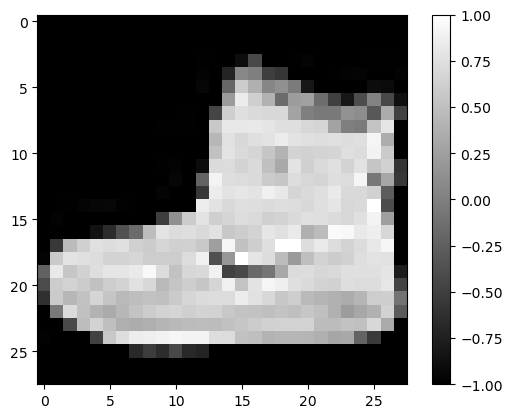

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

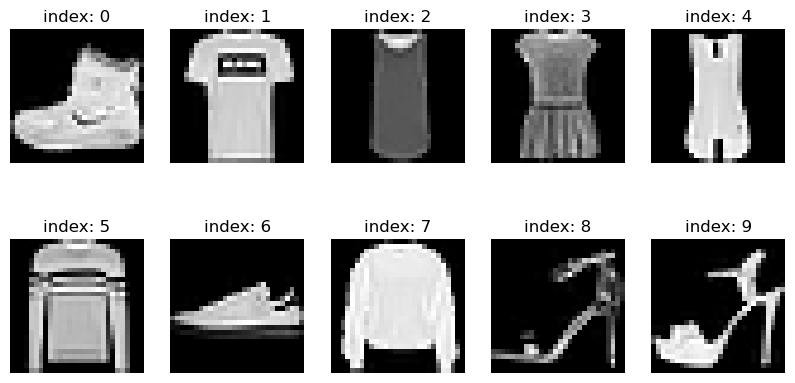

In [8]:
plt.figure(figsize=(10, 5)) #이미지 전체 프레임의 크기

for i in range(10):
    plt.subplot(2, 5, i+1) #plt.subplot(row, col, index): 여러 개의 이미지를 한번에 표시
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off') # 축은 불필요하므로 삭제
plt.show()

## 3. model 생성
### 3-1. 학습 준비

In [9]:
BUFFER_SIZE = 60000 #전체 데이터를 섞기 위해 UFFER_SIZE은 60,000
BATCH_SIZE = 256

from_tensor_slices() 함수: 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있음.<br>
아래 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 함.

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Metal device set to: Apple M2


2022-09-21 23:31:18.247045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-21 23:31:18.247151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 3-2. GAN 모델 생성: DCGAN(Deep Convolutional GAN)
GAN은 두 가지 네트워크를 가짐
* **생성자(Generator)**: 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성함. 즉, 무에서 유를 창조하는 것과 같은 역할.
* **판별자(Discriminator)**: 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real 인지, Fake 인지에 대한 판단 정도를 실숫값으로 출력.
![GAN](GAN.png)

* **Conv2DTranspose**: 일반적인 Conv2D와 반대로 **이미지 사이즈를 넓혀주는 층**<br>
이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키울 것.

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

* 생성자(Generator)는 입력값으로 (batch_size, 100)을 받음.<br>
* 입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됨.
* 첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지남. 이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업을 진행하기 위함.<br><br>


#### 모델 요약

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

### 3-3. 임시 결과물 생성
shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 볼 것.<br>
아직 모델을 학습시키지 않았으니, 큰 의미가 있는 작업은 아님.<br>
* 단, 지금은 학습 중이 아니므로 **training=False**를 설정해야 함.

In [13]:
noise = tf.random.normal([1, 100])

> 텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됨. (내부적으로는 생성자의 call 함수가 호출).

In [14]:
generated_image = generator(noise, training=False)

generated_image.shape

TensorShape([1, 28, 28, 1])

=> [1, 28, 28, 1] 사이즈의 이미지가 생성되었음.<br>
이 이미지를 시각화할 것.
> matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로, 0번째와 3번째 축의 인덱스를 0으로 설정해서 (28, 28) shape의 이미지를 꺼낼 수 있도록 해야 함.

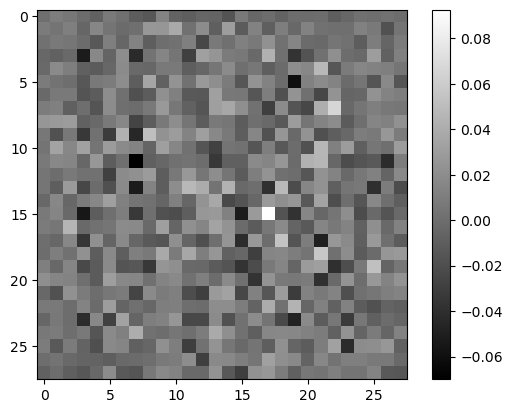

In [15]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### 3-4. 판별자(Discriminator) 구현
가짜 이미지와 진짜 이미지를 입력받으면, 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력<br>
make_discriminator_model 함수를 이용함

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

* Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나감.<br>
첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)으로 줄어듦.
* 마지막으로 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환.<br>
(이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할)
* 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력.

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

#### 위에서 생성한 가짜 이미지(노이즈)를 입력해서 테스트

In [18]:
decision = discriminator(generated_image, training=False)

decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00021202]], dtype=float32)>

=> 텐서 형태로 출력해 줌. 현재는 아무런 의미가 없는 값.

## 4. 모델 최적화
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용.<br>
특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용.<br>
Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0이라고 하면
* 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 **D(fake_image) 값이 1에 가까워지는 것**이 목표
* 판별자 : Real Image 판별값, 즉 **D(real_image)는 1에**, Fake Image 판별값, 즉 **D(fake_image)는 0에 가까워지는 것**이 목표

<br>


### 4-1. 손실 함수 구현
###  단, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었으므로, 추가로 처리가 필요함.
구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있지만, BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정함.<br>
따라서 **from_logits를 True**로 설정해 주어야 **BinaryCrossEntropy**에 입력된 값을 **함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화**한 후 알맞게 계산할 수 있음.


In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output
* **fake_output** : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 **D(fake_image)**
* **real_output** : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 **D(real_image)**

이를 각각 1 또는 0과 비교하기 위해 tf.ones_like()와 tf.zeros_like() 함수를 사용<br><br>


### 4-2. loss 구현
* generator_loss: 생성자는 fake_output가 1에 가까워지기를 바라므로, tf.ones_like 함수와 교차 엔트로피 값을 비교할 것.<br>
 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐.

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

* discriminator_loss: real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산함.<br>
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교할 것.

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 4-3. discriminator accuracy
사실 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다 = 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻.<br>
그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 **둘 다 0.5에 가까워지는 것이 이상적**

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### discriminator_accuracy 함수 설명
ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,
* (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별.
 * => tf.Tensor([False, False, True, True])
* (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
 * => tf.Tensor([0.0, 0.0, 1.0, 1.0])
* (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
 * => 0.5

### 4-4. 최적화 함수(optimizer) 설정: Adam
#### 단, 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다.
learning rate는 0.0001로 설정할 것임.

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것.<br>
샘플은 한 번에 16장을 생성하도록 하고, 매번 같은 노이즈로 생성해야 진전 과정을 확인할 수 있으므로 고정된 seed를 설정할 것.<br>
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 생성할 것임.

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 5. 훈련과정 설계
하나의 미니 배치 당 진행할 train_step 함수를 먼저 만들어야 함.
학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용해야 한다.
> [python decorator(데코레이터) 어렵지 않아요](https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/)

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### train_step 함수 구성
* (1) 입력 데이터: Real Image 역할을 할 __images__ 한 세트를 입력으로 받음.
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 __noise__를 __images__ 한 세트와 같은 크기인 __BATCH_SIZE__ 만큼 생성함.
* (3) __tf.GradientTape()__는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 __with__ 구문 열기.
* (4) generated_images 생성 : generator가 __noise__를 입력받은 후 __generated_images__ 생성.
* (5) discriminator 판별 : discriminator가 Real Image인 __images__와 Fake Image인 __generated_images__를 각각 입력받은 후 __real_output, fake_output 출력__.
* (6) loss 계산 : fake_output, real_output으로 __generator와 discriminator 각각의 loss 계산__.
* (7) accuracy 계산 : fake_output, real_output으로 __discriminator의 정확도 계산__.
* (8) gradient 계산 : __gen_tape__와 __disc_tape__를 활용해 gradient를 자동으로 계산.
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신.
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴.

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정이 담겨 있음<br>
이는 바로 위에서 한 subplot을 이용해서 총 16개의 sample을 시각화하는 과정과 동일. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화하는 것.<br>

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장.
    plt.savefig('{}/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### 정기적으로 모델을 저장하기 위한 checkpoint 생성

In [28]:
checkpoint_dir = os.getenv('HOME')+'/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 6. 학습 진행

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

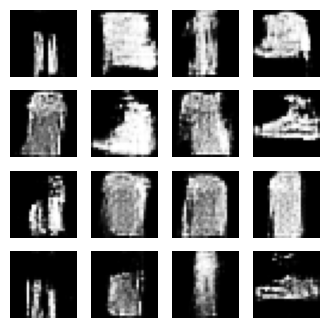

Time for training : 2823 sec


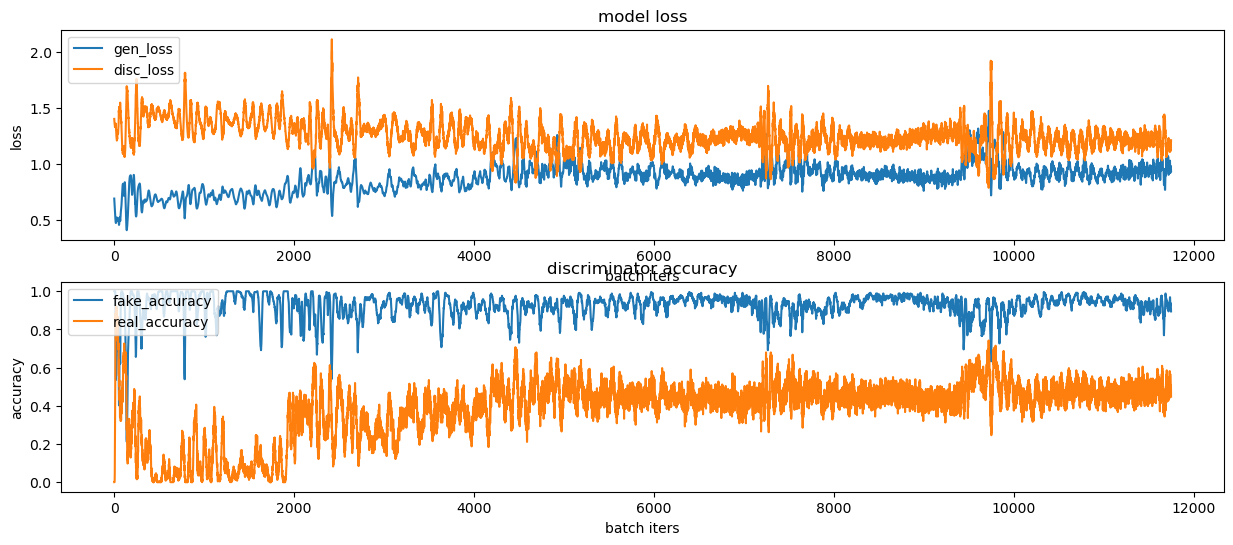

CPU times: user 6min 25s, sys: 8min 55s, total: 15min 21s
Wall time: 47min 4s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인 가능.

### 7. 학습 과정 시각화
imageio 라이브러리를 통해 학습 진행 과정을 GIF 파일로 생성할 것.<br>
(imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식)

In [32]:
anim_file = os.getenv('HOME')+'/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/fashion_mnist_dcgan.gif

/var/folders/p3/fjkwnjwd4dzcfcqt47dlgrm40000gn/T/ipykernel_8328/3911553145.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


-rw-r--r--  1 jsj  staff  2015332  9 22 00:24 /Users/jsj/Aiffel_Project/Deep_Learning/Image_Processing_Basic/DCGAN_Basic/fashion_mnist_dcgan.gif


/var/folders/p3/fjkwnjwd4dzcfcqt47dlgrm40000gn/T/ipykernel_8328/3911553145.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
